# EDA

## 1. Load cleaned data

In [1]:
# Standard imports
from typing import List, Tuple, Dict, Union, Optional, Any, Callable, Iterable, TypeVar, Generic
import time
import re

# Suppress future warnings
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# Third party imports
from geopy.exc import  GeocoderTimedOut, GeocoderUnavailable
from geopy.geocoders import Nominatim
from haversine import haversine
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import numpy as np
import pandas as pd
import plotly.graph_objects as go
import seaborn as sns

# Local imports
from _csv_utils import data_timeplace, DataPathCleaningManager


In [2]:
data_path_manager = DataPathCleaningManager(data_timeplace)

df_olx = data_path_manager.load_df(domain="olx", is_cleaned=True)
df_otodom = data_path_manager.load_df(domain="otodom", is_cleaned=True)

### 1.1 OLX

In [3]:
df_olx

,link,title,price,summary_description,ownership,floor_level,is_furnished,building_type,square_meters,number_of_rooms,rent,voivodeship,city,street
0,https://www.olx.pl/d/oferta/kawalerka-tychy-os...,Kawalerka Tychy oś M,1500.0,OpisWynajmę kawalerkę na ul Moniuszki 1/16 .na...,private,3,False,apartment_building,26,1,400.0,Śląskie,Zawada,Moniuszki 1/16


In [4]:
df_olx.columns

Index(['link', 'title', 'price', 'summary_description', 'ownership',
       'floor_level', 'is_furnished', 'building_type', 'square_meters',
       'number_of_rooms', 'rent', 'voivodeship', 'city', 'street'],
      dtype='object')

### 1.2 otodom

In [5]:
df_otodom.sample(5)

listing  \
                                                  link   
482  https://www.otodom.pl/pl/oferta/scisle-centrum...   
89   https://www.otodom.pl/pl/oferta/studio-flat-ka...   
587  https://www.otodom.pl/pl/oferta/do-wynajecia-k...   
353  https://www.otodom.pl/pl/oferta/3-pokoje-58m2-...   
165  https://www.otodom.pl/pl/oferta/51m-3pokoje-ka...   

                                                        \
                                                 title   
482           Ścisłe Centrum Przy Dworcu PKP Od Zaraz!   
89   Studio Flat Kawalerka Pierwsza Dzielnica Katowice   
587      Do wynajęcia komfortowe 1-pokojowe mieszkanie   
353              * 3 pokoje * 58m2 * Os. Tysiąclecia *   
165    51m 3pokoje Katowice Paderewskiego, A4 business   

                                                                      pricing  \
                                   summary_description remote_service   price   
482  Do wynajęcia piękne 2-pokojowe mieszkanie w św...    unspecified  2200.0   
89   OFERTA WŁAŚCICIELA! 0PLN PROWIZJI! AUTENTYCZNE...           <NA>  1999.0   
587  Sosnowiec Pogoń - do wynajęcia komfortowe 1-po...           <NA>  1700.0   
353  Prezentujemy Państwu nieruchomość znajdującą s...           <NA>  2700.0   
165  The description in English on the bottom of th...           <NA>  2499.0   

                               \
      rent total_rent deposit   
482    NaN     2200.0  2200.0   
89     1.0     2000.0  4000.0   
587  500.0     2200.0  2000.0   
353    NaN     2700.0     NaN   
165    NaN     2499.0  3000.0   

                                              location  \
                                      complete_address   
482  pl. Oddziałów Młodzieży Powstańczej, Śródmieśc...   
89             Góreckiego, Bogucice, Katowice, śląskie   
587                   Pogoń, Pogoń, Sosnowiec, śląskie   
353  ul. Tysiąclecia, Osiedle Tysiąclecia, Katowice...   
165  ul. gen. Józefa Sowińskiego 15, Osiedle Padere...   

                                          ... building_material              \
                                  street  ...          silicate large_panel   
482  pl. Oddziałów Młodzieży Powstańczej  ...             False       False   
89                            Góreckiego  ...             False       False   
587                                Pogoń  ...             False        True   
353                      ul. Tysiąclecia  ...             False        True   
165       ul. gen. Józefa Sowińskiego 15  ...             False        True   

                        additional_information                          \
    reinforced_concrete         no_information duplex air_conditioning   
482               False                  False  False            False   
89                 True                  False  False            False   
587               False                   True  False            False   
353               False                  False  False            False   
165               False                  False  False            False   

                                                             
    separate_kitchen basement utility_room non_smokers_only  
482            False     True        False            False  
89             False     True         True            False  
587            False    False        False            False  
353             True    False        False            False  
165             True     True        False             True  

[5 rows x 73 columns]

In [6]:
df_otodom.columns

MultiIndex([(               'listing',                           'link'),
            (               'listing',                          'title'),
            (               'listing',            'summary_description'),
            (               'listing',                 'remote_service'),
            (               'pricing',                          'price'),
            (               'pricing',                           'rent'),
            (               'pricing',                     'total_rent'),
            (               'pricing',                        'deposit'),
            (              'location',               'complete_address'),
            (              'location',                         'street'),
            (              'location',                           'city'),
            (              'location',                    'voivodeship'),
            (                  'size',                  'square_meters'),
            (                  'size',

### 1.3 Narrowed data to the very local market (5km)

In [7]:
def combine_olx_otodom(df_olx: pd.DataFrame = df_olx, df_otodom: pd.DataFrame = df_otodom):

    # Step 1: Create a mapping
    column_mapping = {
        'link': ('listing', 'link'),
        'title': ('listing', 'title'),
        'price': ('pricing', 'price'),
        'rent': ('pricing', 'rent'),
        'summary_description': ('listing', 'summary_description'),
        'ownership': ('legal_and_availability', 'ownership'),
        'floor_level': ('size', 'floor'),
        'is_furnished': ('equipment', 'furniture'),
        'building_type': ('type_and_year', 'building_type'),
        'square_meters': ('size', 'square_meters'),
        'number_of_rooms': ('size', 'number_of_rooms'),
        'rent': ('pricing', 'rent'),
        'voivodeship': ('location', 'voivodeship'),
        'city': ('location', 'city'),
        'street': ('location', 'street')
    }

    # Step 2: Modify df_olx to have a MultiIndex
    df_olx.columns = pd.MultiIndex.from_tuples([column_mapping[col] if col in column_mapping else (col, '') for col in df_olx.columns])

    # Step 3: Fill missing columns in df_olx
    # Identify missing columns
    missing_columns = set(df_otodom.columns) - set(df_olx.columns)

    # Fill missing columns with NaN or False
    for col in missing_columns:
        if col in [('equipment', 'furniture'),]:  # Add other boolean columns if any
            df_olx[col] = False
        else:
            df_olx[col] = np.nan

    # Reorder df_olx columns to match df_otodom
    df_olx = df_olx.reindex(columns=df_otodom.columns)

    # Add total_rent column
    df_olx[('pricing', 'total_rent')] = df_olx[('pricing', 'price')].add(df_olx[('pricing', 'rent')], fill_value=0)

    # Create complete_address column
    df_olx[('location', 'complete_address')] = df_olx.apply(
    lambda row: ', '.join(
        filter(None, [row[('location', 'street')], row[('location', 'city')], row[('location', 'voivodeship')]])
    ),
    axis=1
)
    pd.set_option('display.max_rows', None)
    df_olx.iloc[0]

    # Fill NaNs
    # Replacing NaN with False
    columns_to_fill_false = [
        ('size', 'attic'),
        ('amenities', 'elevator'),
        ('amenities', 'parking_space'),
        ('equipment', 'no_information'),
        ('equipment', 'stove'),
        ('equipment', 'fridge'),
        ('equipment', 'oven'),
        ('equipment', 'washing_machine'),
        ('equipment', 'TV'),
        ('equipment', 'dishwasher'),
        ('media_types', 'internet'),
        ('media_types', 'telephone'),
        ('media_types', 'cable_TV'),
        ('heating', 'electric'),
        ('heating', 'gas'),
        ('heating', 'other'),
        ('heating', 'boiler_room'),
        ('heating', 'district'),
        ('heating', 'tile_stove'),
        ('security', 'intercom_or_video_intercom'),
        ('security', 'anti_burglary_doors_or_windows'),
        ('security', 'monitoring_or_security'),
        ('security', 'anti_burglary_roller_blinds'),
        ('security', 'alarm_system'),
        ('security', 'enclosed_area'),
        ('windows', 'aluminum'),
        ('windows', 'wooden'),
        ('windows', 'plastic'),
        ('building_material', 'concrete'),
        ('building_material', 'aerated_concrete'),
        ('building_material', 'brick'),
        ('building_material', 'wood'),
        ('building_material', 'other'),
        ('building_material', 'lightweight_aggregate'),
        ('building_material', 'hollow_brick'),
        ('building_material', 'silicate'),
        ('building_material', 'large_panel'),
        ('building_material', 'reinforced_concrete'),
        ('additional_information', 'duplex'),
        ('additional_information', 'air_conditioning'),
        ('additional_information', 'separate_kitchen'),
        ('additional_information', 'basement'),
        ('additional_information', 'utility_room'),
        ('additional_information', 'non_smokers_only'),
    ] 
    for col in columns_to_fill_false:
        df_olx[col] = df_olx[col].fillna(False)

    # Replacing NaN with True
    columns_to_fill_true = [
        ('media_types', 'no_information'),
        ('heating', 'no_information'),
        ('security', 'no_information'),
        ('windows', 'no_information'),
        ('building_material', 'no_information'),
        ('additional_information', 'no_information'),
    ]

    for col in columns_to_fill_true:
        df_olx[col] = df_olx[col].fillna(True)

    # Step 5: Set the same dtypes for df_olx as in df_otodom
    for column in df_otodom.columns:
        if column in df_olx.columns:
            df_olx[column] = df_olx[column].astype(df_otodom[column].dtype)


    # Step 6: Append df_olx to df_otodom
    combined_df = pd.concat([df_otodom, df_olx], ignore_index=True)

    # Step 7: Add deposit_ratio column
    combined_df.loc[:, ("pricing", "deposit_ratio")] = np.where(
        combined_df["pricing"]["total_rent"] != 0,
        (combined_df["pricing"]["deposit"] / combined_df["pricing"]["total_rent"]).round(2),
        np.nan  # or 0, depending on your preference for default value
    )

    # Step 8: Add total price per square meter column
    combined_df.loc[:, ("pricing", "total_rent_sqm")] = (combined_df['pricing']['total_rent'] / combined_df['size']['square_meters']).replace([np.inf, -np.inf], np.nan)

    # Step 9: Reorder columns

    columns = combined_df.columns.tolist()

    new_and_old_columns = [
        (8, columns.index(("pricing", "deposit_ratio"))),
        (7, columns.index(("pricing", "total_rent_sqm"))),
    ]

    for new, old in new_and_old_columns:
        columns.insert(new, columns.pop(old))

    combined_df = combined_df[columns]

    return combined_df

combined_df = combine_olx_otodom(df_olx, df_otodom)

offers_5km_df = combined_df[
    (combined_df["location"]["city"] == "będziński")
    | (combined_df["location"]["city"] == "Zawada")
].copy()

offers_5km_df.tail()

listing  \
                                                   link   
981   https://www.otodom.pl/pl/oferta/nowy-apartamen...   
1053  https://www.otodom.pl/pl/oferta/bedzin-kawaler...   
1071  https://www.otodom.pl/pl/oferta/dwupokojowe-mi...   
1072  https://www.otodom.pl/pl/oferta/komfortowa-dob...   
1105  https://www.olx.pl/d/oferta/kawalerka-tychy-os...   

                                                         \
                                                  title   
981     Nowy apartament | Osiedle Rycerskie | Od zaraz!   
1053                     Będzin, kawalerka do wynajęcia   
1071  Dwupokojowe mieszkanie tuż po generalnym remoncie   
1072             Komfortowa dobrze wyposażona kawalerka   
1105                               Kawalerka Tychy oś M   

                                                                        \
                                    summary_description remote_service   
981   Tylko w Realton!ENGLISH -> Please contact via ...           <NA>   
1053  OFERTA WYŁĄCZNOŚĆ KAWALERKA do wynajęcia!!!Ofe...           <NA>   
1071  Zostań pierwszym Najemcą tuż po generalnym rem...           <NA>   
1072  Komfortowe, wyremontowane i wyposażone we wszy...           <NA>   
1105  OpisWynajmę kawalerkę na ul Moniuszki 1/16 .na...           <NA>   

     pricing                                                         ...  \
       price   rent total_rent total_rent_sqm deposit deposit_ratio  ...   
981   3500.0    NaN     3500.0      45.454545     NaN           NaN  ...   
1053   690.0    NaN      690.0           30.0     NaN           NaN  ...   
1071  1490.0  300.0     1790.0      59.666667  2500.0          1.40  ...   
1072  1200.0  780.0     1980.0      63.870968  2000.0          1.01  ...   
1105  1500.0  400.0     1900.0      73.076923     NaN           NaN  ...   

     building_material                                 additional_information  \
              silicate large_panel reinforced_concrete         no_information   
981              False       False               False                   True   
1053             False       False               False                  False   
1071             False       False               False                   True   
1072             False        True               False                  False   
1105             False       False               False                   True   

                                                                     \
     duplex air_conditioning separate_kitchen basement utility_room   
981   False            False            False    False        False   
1053  False            False             True    False        False   
1071  False            False            False    False        False   
1072  False            False            False     True        False   
1105  False            False            False    False        False   

                       
     non_smokers_only  
981             False  
1053            False  
1071            False  
1072            False  
1105            False  

[5 rows x 75 columns]

In [8]:
pd.reset_option('display.max_rows')

In [9]:
offers_5km_df.dtypes.to_dict()

{('listing', 'link'): string[python],
 ('listing', 'title'): string[python],
 ('listing', 'summary_description'): string[python],
 ('listing', 'remote_service'): string[python],
 ('pricing', 'price'): dtype('float64'),
 ('pricing', 'rent'): dtype('float64'),
 ('pricing', 'total_rent'): dtype('float64'),
 ('pricing', 'total_rent_sqm'): Float64Dtype(),
 ('pricing', 'deposit'): dtype('float64'),
 ('pricing', 'deposit_ratio'): dtype('float64'),
 ('location', 'complete_address'): string[python],
 ('location', 'street'): string[python],
 ('location', 'city'): string[python],
 ('location', 'voivodeship'): string[python],
 ('size', 'square_meters'): Int64Dtype(),
 ('size', 'number_of_rooms'): Int64Dtype(),
 ('size', 'floor'): Int64Dtype(),
 ('size', 'attic'): dtype('bool'),
 ('size', 'building_floors'): Int64Dtype(),
 ('legal_and_availability', 'available_from'): string[python],
 ('legal_and_availability', 'completion'): string[python],
 ('legal_and_availability', 'ownership'): string[python],

In [10]:
offers_5km_df[('listing', 'link')].duplicated().sum()

0

## 2. EDA

### 2.1 Numerical data

#### A. Furnished and unfurnished

In [11]:
offers_5km_df.describe()

pricing                                                       \
             price        rent   total_rent total_rent_sqm      deposit   
count    33.000000   18.000000    33.000000           33.0    25.000000   
mean   1744.848485  504.777778  2020.181818       47.58918  2544.000000   
std     639.893161  251.790425   676.300666      14.460784   941.775805   
min     690.000000    1.000000   690.000000           25.0  1200.000000   
25%    1300.000000  394.000000  1577.000000           33.2  2000.000000   
50%    1600.000000  510.000000  1950.000000      50.870968  2500.000000   
75%    2000.000000  700.000000  2502.000000          56.25  3000.000000   
max    3500.000000  850.000000  3500.000000           78.0  5000.000000   

                             size                                            \
      deposit_ratio square_meters number_of_rooms     floor building_floors   
count     25.000000          33.0            33.0      31.0            26.0   
mean       1.226400     43.666667        2.060606  1.677419        3.307692   
std        0.309433     13.628249         0.74747  1.375672        0.928191   
min        0.670000          23.0             1.0       0.0             2.0   
25%        1.000000          36.0             2.0       1.0            2.25   
50%        1.110000          44.0             2.0       1.0             4.0   
75%        1.500000          50.0             2.0       2.5             4.0   
max        1.960000          88.0             4.0       4.0             5.0   

      type_and_year  
         build_year  
count     11.000000  
mean    1992.363636  
std       30.777501  
min     1929.000000  
25%     1975.000000  
50%     1983.000000  
75%     2020.000000  
max     2023.000000

In [12]:
len(offers_5km_df)

33

In [41]:
furnished_offers = offers_5km_df[
    offers_5km_df["equipment"]["furniture"] == True
]
non_furnished_offers = offers_5km_df[
    offers_5km_df["equipment"]["furniture"] == False
]

#### B. Furnished

In [42]:
furnished_offers.describe()

pricing                                                       \
             price        rent   total_rent total_rent_sqm      deposit   
count    22.000000   15.000000    22.000000           22.0    21.000000   
mean   1792.727273  487.066667  2124.818182      51.859405  2578.571429   
std     564.313167  259.432751   546.196078      12.536746   917.955803   
min     950.000000    1.000000   950.000000           25.0  1200.000000   
25%    1385.000000  346.000000  1795.500000       46.42094  2000.000000   
50%    1750.000000  490.000000  1986.000000      52.191667  2500.000000   
75%    1975.000000  700.000000  2501.500000      61.070513  3000.000000   
max    3200.000000  780.000000  3200.000000           78.0  5000.000000   

                             size                                            \
      deposit_ratio square_meters number_of_rooms     floor building_floors   
count     21.000000          22.0            22.0      21.0            18.0   
mean       1.220952     41.818182        2.045455  1.666667        3.333333   
std        0.313383      9.240884        0.843873  1.354006        0.840168   
min        0.670000          25.0             1.0       0.0             2.0   
25%        1.000000          34.5            1.25       1.0             3.0   
50%        1.110000          41.5             2.0       2.0             4.0   
75%        1.400000         48.75            2.75       2.0             4.0   
max        1.960000          60.0             4.0       4.0             4.0   

      type_and_year  
         build_year  
count      7.000000  
mean    2002.142857  
std       24.120728  
min     1970.000000  
25%     1980.000000  
50%     2018.000000  
75%     2022.000000  
max     2023.000000

#### C. Unfurnished

In [43]:
non_furnished_offers.describe()

pricing                                                       \
             price        rent   total_rent total_rent_sqm      deposit   
count    11.000000    3.000000    11.000000           11.0     4.000000   
mean   1649.090909  593.333333  1810.909091      39.048729  2362.500000   
std     791.460101  231.588716   874.567945      14.790497  1193.995394   
min     690.000000  400.000000   690.000000      26.315789  1450.000000   
25%    1150.000000  465.000000  1150.000000       28.67823  1487.500000   
50%    1450.000000  530.000000  1450.000000      32.954545  2000.000000   
75%    1900.000000  690.000000  2515.000000      48.543599  2875.000000   
max    3500.000000  850.000000  3500.000000      73.076923  4000.000000   

                             size                                            \
      deposit_ratio square_meters number_of_rooms     floor building_floors   
count      4.000000          11.0            11.0      10.0             8.0   
mean       1.255000     47.363636        2.090909       1.7            3.25   
std        0.331612     19.810466         0.53936  1.494434        1.164965   
min        0.940000          23.0             1.0       0.0             2.0   
25%        0.985000          37.0             2.0       1.0             2.0   
50%        1.250000          44.0             2.0       1.0             3.5   
75%        1.520000          51.0             2.0      2.75             4.0   
max        1.580000          88.0             3.0       4.0             5.0   

      type_and_year  
         build_year  
count      4.000000  
mean    1975.250000  
std       37.151716  
min     1929.000000  
25%     1959.750000  
50%     1976.500000  
75%     1992.000000  
max     2019.000000

#### D. Summary

**Insights Big Picture Numerical Data:**

1. **The offers**<br>
- Are in the radius of the area of `5`<br>
from `"Mierzęcice, Będziński, Śląskie"`, near the regional international airport.<br>
- The total number of offers is `33`.
2. **Average Total Rent**:<br>
- The median total rent (total_rent) for furnished properties is `1986.00` PLN,<br>
- For unfurnished properties is `1450.00` PLN,<br>
- The overall median considering both types is `1950.00` PLN.
3. **Rent Range and Standard Deviation**:<br>
- The rent range for furnished properties is from `950` PLN to `3200` PLN, with a standard deviation of `546.20` PLN.<br>
- The rent range for unfurnished properties is from `690` PLN to `3500` PLN, with a standard deviation of `874.57` PLN.<br>
- This indicates significant variation in rent prices across different types of properties.
4. **Property Size:**<br>
- The median size of all properties in the dataset is approximately `50.87` square meters.
- The size of properties ranges from a minimum of `23` square meters to a maximum of `78` square meters.
5. **Build Year**:<br>
- The properties in the dataset were constructed over a wide range of years, from `1929` to `2023`.
- The median build year for all properties is `1983.36`, indicating a mix of older and newer constructions.
6. **Floor Information**:<br>
- The properties are located on various floors, with an median floor number of `1.00`.
- The range of floors spans from the ground floor up to the `5th` floor.
- The median number of floors in the buildings is approximately `4.0`, suggesting that most properties are part of low to mid-rise buildings.
7. **Cost per Square Meter**:<br>
- The median cost per square meter for furnished properties is `52.19` PLN, and for unfurnished properties, it is `32.95` PLN.
- The cost per square meter ranges from `25` PLN to `78` PLN for furnished properties, and from `26.32` PLN to `73.08` PLN for unfurnished properties.

### 2.2 Total rent

In [13]:
aesthetics_plots = {
	'title_size': 16,
    'y_and_x_label_size': 12,
	'fontweight': 'bold',
	'label_color': "#435672",
    "palette": "viridis",
    "figsize": {
        "multiplot": (15, 10),  # (width, height) in inches
        "singleplot": (8, 6),
        },
    }

def set_plot_aesthetics(ax, title=None, xlabel=None, ylabel=None, title_color="#435672", tick_color="#435672", fontweight='bold'):
    if title:
        ax.set_title(title, color=title_color, fontweight=fontweight)
    if xlabel:
        ax.set_xlabel(xlabel, fontweight=fontweight)
    if ylabel:
        ax.set_ylabel(ylabel, fontweight=fontweight)
    ax.tick_params(colors=tick_color, which='both')  # For both major and minor ticks
    ax.yaxis.label.set_color(tick_color)  # Y-axis label color
    ax.xaxis.label.set_color(tick_color)  # X-axis label color
    for spine in ax.spines.values():  # Spine color
        spine.set_edgecolor(tick_color)

def plot_distribution(data_series: pd.Series, title: str, kde_setting: bool, bin: int, x_ticks_number: int, x_ticks_rotation: bool):
    fig, ax = plt.subplots(figsize=aesthetics_plots['figsize']['singleplot'])

    cmap = plt.get_cmap('viridis')
    color = cmap(0.5)  # Using a single color, you can adjust this as needed

    sns.histplot(data_series, ax=ax, kde=kde_setting, bins=bin, color=color)
    set_plot_aesthetics(ax, title)

    ax.xaxis.set_major_locator(ticker.MaxNLocator(nbins=x_ticks_number))

    if x_ticks_rotation:
        ax.xaxis.set_major_locator(ticker.FixedLocator(ax.get_xticks()))
        ax.set_xticklabels(ax.get_xticklabels(), rotation=45)

    # Add annotations for each bar
    for p in ax.patches:
        # Calculate the percentage of the total
        percentage = (p.get_height() / len(data_series)) * 100
        # Place the annotation above the bar
        if percentage > 0:
            ax.annotate(f"{percentage:.1f}%", (p.get_x() + p.get_width() / 2., p.get_height()),
                        ha='center', va='bottom', fontsize=10, weight='bold', color=aesthetics_plots['label_color'], xytext=(0, 2),
                        textcoords='offset points')

    plt.tight_layout()
    plt.show()

In [14]:
def advanced_statistical_analysis(df: pd.DataFrame = offers_5km_df):
    price_data = df['pricing']['total_rent']

    # Central Tendency Measures
    mean_price = price_data.mean()
    median_price = price_data.median()
    mode_price = price_data.mode()[0]

    # Variability Measures
    std_dev_price = price_data.std()
    variance_price = price_data.var()
    range_price = price_data.max() - price_data.min()
    iqr_price = np.percentile(price_data, 75) - np.percentile(price_data, 25)

    # Skewness and Kurtosis
    skewness_price = price_data.skew()
    kurtosis_price = price_data.kurtosis()

    # Quantile Analysis
    quantiles_price = price_data.quantile([0.25, 0.5, 0.75, 0.9, 0.95, 0.99])

    # Outlier Detection: Using the 1.5*IQR rule
    lower_bound = np.percentile(price_data, 25) - 1.5 * iqr_price
    upper_bound = np.percentile(price_data, 75) + 1.5 * iqr_price
    outliers_upper = price_data[(price_data >= upper_bound)].count()
    outliers_lower = price_data[(price_data <= lower_bound)].count()
    outlier_total = outliers_upper + outliers_lower

    advanced_statistics = {
        "Mean": mean_price.round(2),
        "Median": median_price,
        "Standard Deviation": std_dev_price.round(2),
        "Mode": mode_price,
        "Variance": variance_price.round(2),
        "Range": range_price,
        "Interquartile Range (IQR)": iqr_price,
        "Skewness": skewness_price.round(2),
        "Kurtosis": kurtosis_price.round(2),
        "Quantiles": quantiles_price,
        "Outlier Lower Bound": lower_bound,
        "Outlier Upper Bound": upper_bound,
        "Number of Lower Bound": outliers_upper,
        "Number of Upper Bound": outliers_lower,
        "Number of Outliers": outlier_total,
        "Total Number of Listings": price_data.count(),
        "Ratio of Outliers to Total Listings": str((outlier_total / price_data.count()).round(2) * 100)+ "%",
    }

    print("Total Price, Advanced Statistics:")
    return advanced_statistics

advanced_statistical_analysis(offers_5km_df)

Total Price, Advanced Statistics:


{'Mean': 2020.18,
 'Median': 1950.0,
 'Standard Deviation': 676.3,
 'Mode': 2500.0,
 'Variance': 457382.59,
 'Range': 2810.0,
 'Interquartile Range (IQR)': 925.0,
 'Skewness': 0.01,
 'Kurtosis': -0.47,
 'Quantiles': 0.25    1577.0
 0.50    1950.0
 0.75    2502.0
 0.90    2690.0
 0.95    3020.0
 0.99    3404.0
 Name: total_rent, dtype: float64,
 'Outlier Lower Bound': 189.5,
 'Outlier Upper Bound': 3889.5,
 'Number of Lower Bound': 0,
 'Number of Upper Bound': 0,
 'Number of Outliers': 0,
 'Total Number of Listings': 33,
 'Ratio of Outliers to Total Listings': '0.0%'}

**Insights Total Rent:**

1. Rent Tendency:
Most rent prices cluster around a lower to moderate range, with the median at `1950.00` PLN.<br>
However, the mean rent being slightly higher at `2020.18` PLN and the mode at `2500.00` PLN indicates a presence of higher-priced rentals.<br>
This suggests that while a majority of the rents are more affordable, there is a significant portion that is priced higher.

2. Exceptional Rents:
The data shows no outliers, as all rents fall within the outlier bounds of `189.5` PLN to `3889.5` PLN.<br>
This implies that there aren't rents that are exceptionally higher or lower than what's typical in this dataset.<br>
Unlike the previous understanding of about `6%` of rents being unusually high or low,<br>
the new data suggests a more uniform distribution of rent prices.

3. Variation in Rent Prices:
The range of rent prices is quite extensive (`2810.00` PLN), with a significant standard deviation (`676.30` PLN),<br>
indicating a broad spectrum of rent prices. While `75%` of rents are below `2502.00` PLN,<br>
showing that most rents are within a reasonable range, the rents progressively increase at the higher end.<br>
The top `5%` of properties are above `3020.00` PLN, and the top `1%` reach `3404.00` PLN.<br>
This demonstrates a clear divide between the majority of affordable rentals and a smaller segment of premium, high-priced properties.

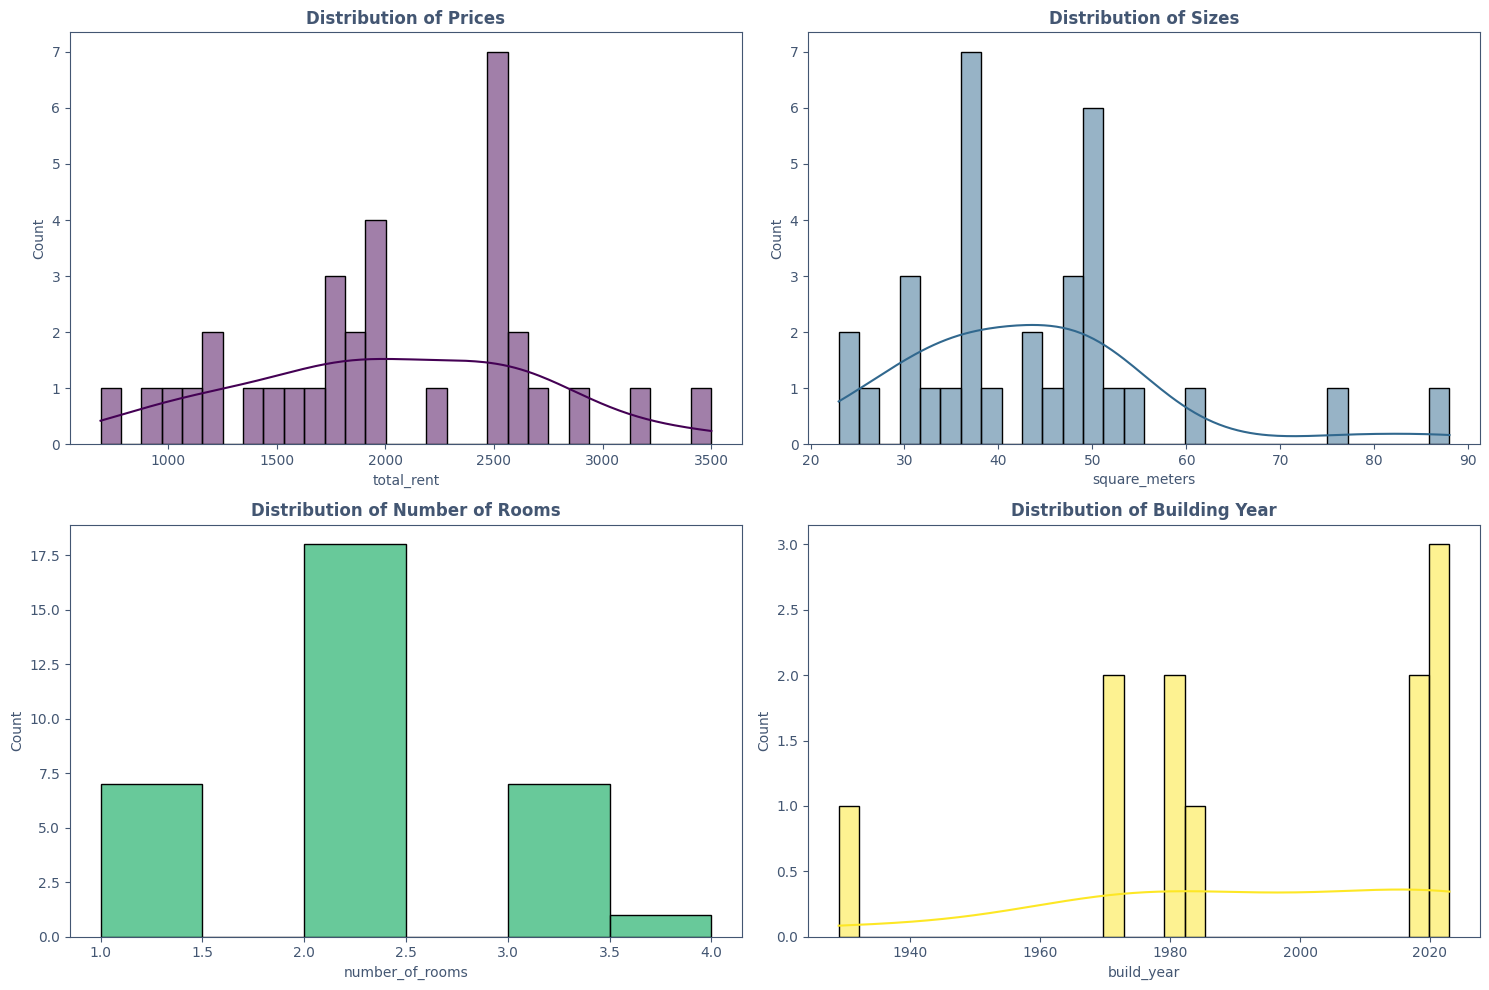

In [16]:
def plot_distributions(offers_5km_df: pd.DataFrame):
    fig, axes = plt.subplots(nrows=2, ncols=2, figsize=aesthetics_plots['figsize']['multiplot'])

    cmap = plt.get_cmap('viridis')
    colors = cmap(np.linspace(0, 1, 4))

    titles = ['Distribution of Prices', 'Distribution of Sizes', 'Distribution of Number of Rooms', 'Distribution of Building Year']
    data_columns = ['pricing.total_rent', 'size.square_meters', 'size.number_of_rooms', 'type_and_year.build_year']
    kde_settings = [True, True, False, True]
    bins = [30, 30, 6, 30]

    for ax, title, color, data_column, kde_setting, bin in zip(axes.flat, titles, colors, data_columns, kde_settings, bins):
        sns.histplot(offers_5km_df[data_column.split('.')[0]][data_column.split('.')[1]].astype('float'), ax=ax, kde=kde_setting, bins=bin, color=color)
        set_plot_aesthetics(ax, title)

    plt.tight_layout()
    plt.show()

plot_distributions(offers_5km_df)

**Insights Top Numerical Data:**

1. **Rental Prices**:<br>
Rentals are concentrated around `2500` PLN, with high-priced rentals being rare.

1. **Apartment Sizes**:<br>
Smaller apartments are more common (around `50 m2`) than larger ones, there are also handful very small ones around `38 m2`.
Most have only `2` rooms extra besides the bathroom and kitchen or corridor.

1. **Building Ages**:<br>
A lot of buildings were put up around the year `1980`, and there's a recent surge in new ones in `2020`.<br>
You don't see many old buildings up for rent.

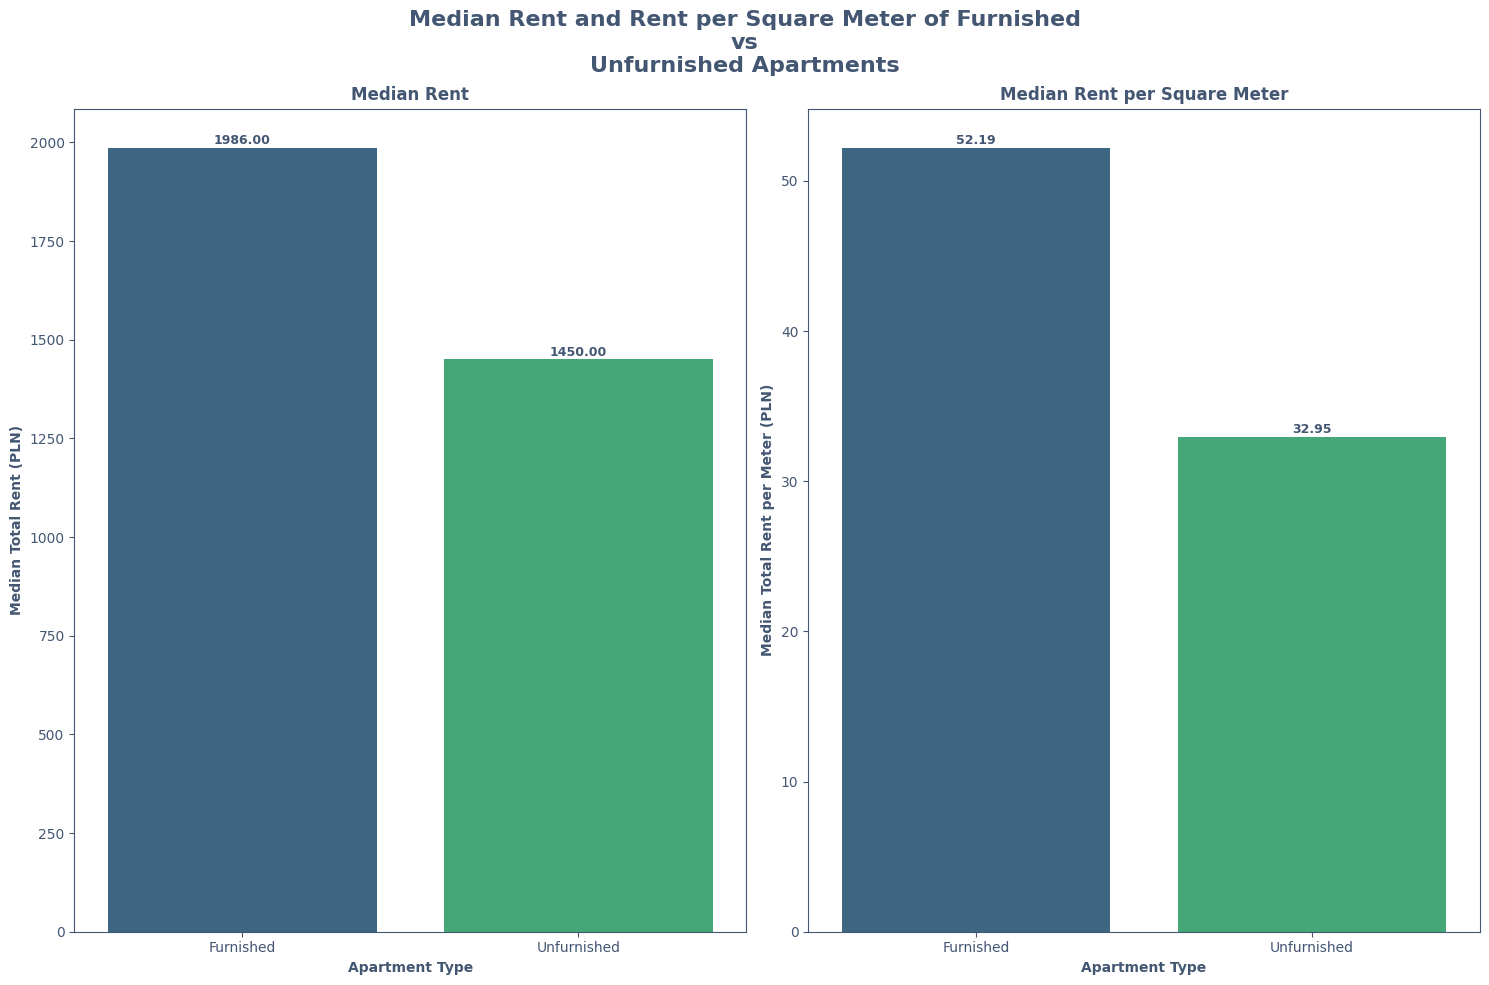

Median Differences:
Furnished vs Unfurnished: 536.0 PLN
Furnished vs Unfurnished per Square Meter: 19.0 PLN


In [17]:
def set_plot_aesthetics(ax, title=None, xlabel=None, ylabel=None, title_color="#435672", tick_color="#435672", fontweight='bold'):
    if title:
        ax.set_title(title, color=title_color, fontweight=fontweight)
    if xlabel:
        ax.set_xlabel(xlabel, fontweight=fontweight)
    if ylabel:
        ax.set_ylabel(ylabel, fontweight=fontweight)
    ax.tick_params(colors=tick_color, which='both')  # For both major and minor ticks
    ax.yaxis.label.set_color(tick_color)  # Y-axis label color
    ax.xaxis.label.set_color(tick_color)  # X-axis label color
    for spine in ax.spines.values():  # Spine color
        spine.set_edgecolor(tick_color)

def plot_distribution(offers_5km_df: pd.DataFrame):

    # No information about furniture delete
    # refactor

    # Calculate medians
    median_furnished = offers_5km_df[offers_5km_df['equipment']['furniture']]['pricing']['total_rent'].median()
    median_unfurnished = offers_5km_df[~offers_5km_df['equipment']['furniture']]['pricing']['total_rent'].median()
    
    median_furnished_sqm = (offers_5km_df[offers_5km_df['equipment']['furniture']]['pricing']['total_rent_sqm']).median()
    median_unfurnished_sqm = (offers_5km_df[~offers_5km_df['equipment']['furniture']]['pricing']['total_rent_sqm']).median()

    # Prepare data for plotting
    median_data_furnishing = pd.DataFrame({
        'Furniture': ['Furnished', 'Unfurnished'],
        'Median Rent': [median_furnished, median_unfurnished]
    })

    median_data_square_meter = pd.DataFrame({
        'Furniture': ['Furnished', 'Unfurnished'],
        'Median Rent per Square Meter': [median_furnished_sqm, median_unfurnished_sqm]
    })

    title = 'Median Rent and Rent per Square Meter of Furnished\nvs\nUnfurnished Apartments'

    # Create a figure with two subplots
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=aesthetics_plots['figsize']['multiplot'])

    # Plotting Median Rent
    sns.barplot(x='Furniture', y='Median Rent', data=median_data_furnishing, ax=ax1, palette='viridis')

    # Plotting Median Rent per Square Meter
    sns.barplot(x='Furniture', y='Median Rent per Square Meter', data=median_data_square_meter, ax=ax2, palette='viridis')

    for ax in [ax1, ax2]:
        for p in ax.patches:
            ax.annotate(f'{p.get_height():.2f}', (p.get_x() + p.get_width() / 2., p.get_height()), 
                        ha='center', va='center', fontsize=9, color=aesthetics_plots["label_color"], fontweight='bold',
                        xytext=(0, 5),
                        textcoords='offset points')
            
    # Apply aesthetics to each subplot
    set_plot_aesthetics(ax1, title='Median Rent', xlabel='Apartment Type', ylabel='Median Total Rent (PLN)')
    set_plot_aesthetics(ax2, title='Median Rent per Square Meter', xlabel='Apartment Type', ylabel='Median Total Rent per Meter (PLN)')

    # Set the main title for the figure
    fig.suptitle(title, color="#435672", fontsize=aesthetics_plots['title_size'], fontweight='bold')


    plt.tight_layout()
    plt.show()

    print(f"Median Differences:")
    print(f"Furnished vs Unfurnished: {abs(median_furnished - median_unfurnished)} PLN")
    print(f"Furnished vs Unfurnished per Square Meter: {(abs(median_furnished_sqm - median_unfurnished_sqm)).round()} PLN")

plot_distribution(offers_5km_df)

**Insights Median Prices Furnishes vs Unfurnished:**

1. **Higher Median Rent for Furnished Apartments**:<br>
Furnished apartments have a higher median rent compared to unfurnished ones by `536` PLN.<br>
This suggests that renters pay a premium for the added convenience of a furnished space.

1. **Smaller Difference in Price per Square Meter**:<br>
When looking at the rent price per square meter,<br>
furnished apartments are about `19,24` PLN (`+36%`) more expensive than unfurnished ones.<br>

In [18]:
def show_categorical_data_percentage_distribution(
        df: pd.DataFrame, 
        categorical_column: Tuple[str, str], 
        distribution_column: Tuple[str, str], 
        title: str,
        x_ticks_number: int = 10,
        y_ticks_number: int = 8,
        x_ticks_rotation: bool = True,
        y_ticks_rotation: bool = True,
    ):
    
    # Create a subset DataFrame with only the required columns
    plot_data = df[[categorical_column, distribution_column]].dropna()

    # Set up the matplotlib figure
    plt.figure(figsize=(14, 7))

    # Get unique building types from the categorical column
    building_types = plot_data[categorical_column].unique()

    # Generate a list of colors, one for each building type
    my_palette = ['#bfed2d'] + ['#00c37f'] + ["#007e90"] + ['#51006f'] + ["#FF9F66"]

    ax = plt.gca()  # Get the current Axes instance on the current figure matching the given keyword args, or create one.

    # Plot each building type's histogram
    for building_type, color in zip(building_types, my_palette):
        # Select the rows where the building type matches and is not null
        subset = plot_data[plot_data[categorical_column] == building_type]
        sns.histplot(subset[distribution_column], kde=False, color=color, label=building_type, ax=ax)

    
    # Add some formatting and titles
    x_axis_title = distribution_column[1].replace('_', ' ')

    plt.title(title, color=aesthetics_plots['label_color'], fontsize=aesthetics_plots['title_size'], weight=aesthetics_plots['fontweight'])
    plt.xlabel(x_axis_title, color=aesthetics_plots['label_color'], fontsize=aesthetics_plots['y_and_x_label_size'], weight=aesthetics_plots['fontweight'])
    plt.ylabel('Frequency', color=aesthetics_plots['label_color'], fontsize=aesthetics_plots['y_and_x_label_size'], weight=aesthetics_plots['fontweight'])

    legend = plt.legend(title=x_axis_title)
    plt.setp(legend.get_title(), fontsize='large', color=aesthetics_plots['label_color'], weight='bold')
    plt.setp(legend.get_texts(), color=aesthetics_plots['label_color'])

    # Customize x-axis ticks
    ax.xaxis.set_major_locator(ticker.MaxNLocator(nbins=x_ticks_number))
    ax.yaxis.set_major_locator(ticker.MaxNLocator(nbins=y_ticks_number))

    if x_ticks_rotation:
        ax.xaxis.set_major_locator(ticker.FixedLocator(ax.get_xticks()))
        ax.set_xticklabels(ax.get_xticklabels(), rotation=45)
        
    if y_ticks_rotation:
        ax.yaxis.set_major_locator(ticker.FixedLocator(ax.get_yticks()))
        ax.set_yticklabels(ax.get_yticklabels(), rotation=45)

    plt.xticks(color=aesthetics_plots['label_color'])
    plt.yticks(color=aesthetics_plots['label_color'])
    
    sns.despine(right=True, top=True)

    # Add annotations for each bar
    for p in ax.patches:
        # Calculate the percentage of the total
        percentage = (p.get_height() / len(df)) * 100
        # Place the annotation above the bar
        if percentage > 0:
            ax.annotate(f"{percentage:.1f}%", (p.get_x() + p.get_width() / 2., p.get_height()),
                        ha='center', va='bottom', fontsize=10, color=aesthetics_plots['label_color'], xytext=(0, 8),
                        textcoords='offset points')

    # Show the plot
    plt.show()

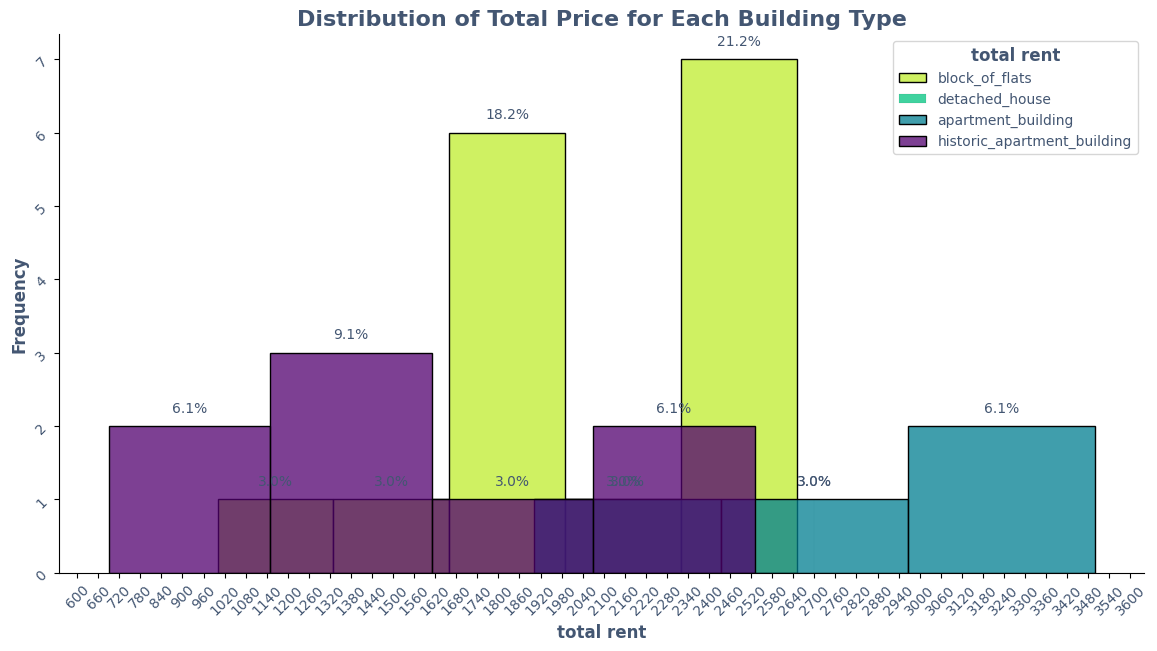

In [19]:
show_categorical_data_percentage_distribution(
    offers_5km_df,  
    ('type_and_year', 'building_type'),
    ('pricing', 'total_rent'),
    'Distribution of Total Price for Each Building Type',
    x_ticks_number= 60,
    x_ticks_rotation= True
    )

In [45]:
offers_5km_df[[('type_and_year', 'building_type'), ('pricing', 'total_rent')]].value_counts().reset_index(name='count').sort_values(by=[('type_and_year', 'building_type'), ('pricing', 'total_rent')])

,"(type_and_year, building_type)","(pricing, total_rent)",count
14,apartment_building,1900.0,1
15,apartment_building,2900.0,1
25,apartment_building,3200.0,1
24,apartment_building,3500.0,1
23,block_of_flats,1000.0,1
22,block_of_flats,1400.0,1
21,block_of_flats,1701.0,1
20,block_of_flats,1800.0,1
19,block_of_flats,1900.0,1
1,block_of_flats,1950.0,2


**Insights from Distribution of Total Price for Each Building Type**:
1. **Apartment buildings**:<br>
have a wide price distribution from `1900` to `3500`, with a notable concentration between the range of `2900` to `3.500`, most low budget-friendly offers in the data.

1. **Block of Flats**:<br>
Prices for blocks of flats show a slightly wider spread in the histogram, extending into the mid-price range (`1000` to `2650`).<br>
The presence in both lower and mid-range pricing suggests a mix of both economical and upscale options for renters.

1. **Historic Apartment Buildings**:<br>
The distribution for historic apartment buildings tends to stretch across a broad range of prices (`690` to `2530`).

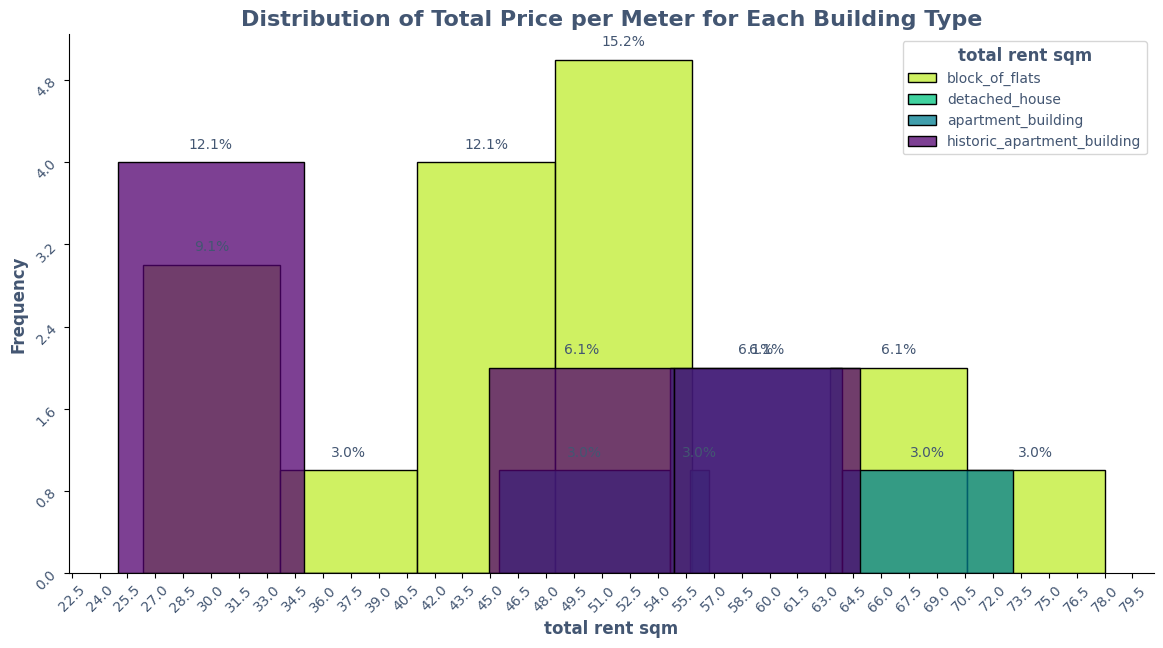

In [20]:
show_categorical_data_percentage_distribution(
    offers_5km_df,  
    ('type_and_year', 'building_type'),
    ('pricing', 'total_rent_sqm'),
    'Distribution of Total Price per Meter for Each Building Type',
    x_ticks_number= 40,
    x_ticks_rotation= True
    )

In [51]:
def show_distribution_details(args):

    counts_df = offers_5km_df[args].value_counts().reset_index(name='count')

    counts_df[args[1]] = counts_df[args[1]].round()

    return counts_df.sort_values(by=args)

show_distribution_details([('type_and_year', 'building_type'), ('pricing', 'total_rent_sqm')])

,"(type_and_year, building_type)","(pricing, total_rent_sqm)",count
0,apartment_building,45.0,1
15,apartment_building,62.0,1
27,apartment_building,63.0,1
26,apartment_building,73.0,1
25,block_of_flats,26.0,1
24,block_of_flats,27.0,1
23,block_of_flats,33.0,1
22,block_of_flats,39.0,1
21,block_of_flats,43.0,1
20,block_of_flats,46.0,1


**Insights from Distribution of Total Price per Meter for Each Building Type**:

1. **The total price per meter for apartment buildings**:<br>
is concentrated heavily around `50 PLN per sqm`.
1. **Historic apartment buildings**:<br>
show a price per meter spread over a wider range, more in the lower end and high end (`8` to `128`) in the peak around `24`.
1. **Terraced houses**:<br>
 while less common, show a consistently lower price per meter (`4` to `24`), suggesting higher space for a lower per meter price.

 1. **The total price per meter for apartment buildings**:<br>
The total price per square meter for apartment buildings shows values at `45`, `62`, `63`, and `73` PLN per sqm. The distribution is somewhat spread out, with the highest frequency noted at `62` and `63` PLN per sqm.
1. **Historic apartment buildings**:<br>
Block of flats have a range of prices per square meter from `26` to `78` PLN per sqm, with a higher concentration around the `46` to `53` PLN per sqm range. This suggests a diversity in the price per square meter, accommodating both budget-friendly and higher-priced preferences.
1. **Terraced houses**:<br>
The price per square meter for historic apartment buildings is distributed across `25` to `65` PLN per sqm, with no listings at the extreme low and high ends (`8` to `128` PLN per sqm) as previously stated. The data shows that historic buildings tend to have a more moderate price range, with some listings at higher values, but not as widely spread as initially indicated.

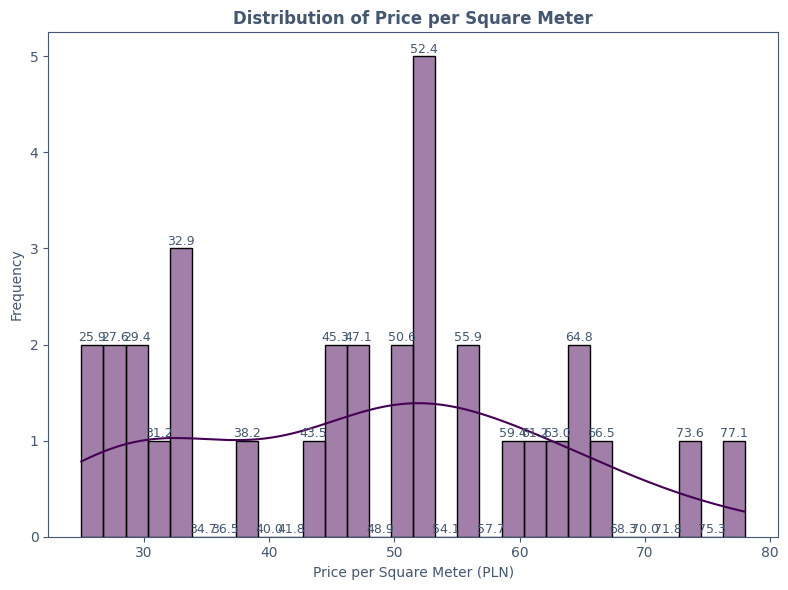

In [21]:
def plot_distribution(offers_5km_df: pd.DataFrame):

    # Calculation with handling of potential division by zero or NaN values
    plot_data = offers_5km_df['pricing']['total_rent_sqm']
    plot_data = plot_data.dropna().round().astype('float')

    cmap = plt.get_cmap('viridis')
    colors = cmap(np.linspace(0, 1, 4))
    color = colors[0]
    title = 'Distribution of Price per Square Meter'

    fig, ax = plt.subplots(figsize=aesthetics_plots['figsize']['singleplot'])
    hist = sns.histplot(plot_data, kde=True, bins=30, color=color, ax=ax)
    ax.set_xlabel('Price per Square Meter (PLN)')
    ax.set_ylabel('Frequency')

    for p in hist.patches:
        bin_center = p.get_x() + p.get_width() / 2
        ax.annotate(f'{bin_center:.1f}', (bin_center, p.get_height()), 
                    ha='center', va='center', fontsize=9, color=aesthetics_plots["label_color"], xytext=(0, 5),
                    textcoords='offset points')
        
    set_plot_aesthetics(ax, title)

    plt.tight_layout()
    plt.show()

plot_distribution(offers_5km_df)

**Insights Price Per Square Meter:**

1. **Common Rent Prices**:<br>
Most apartments cost about `52 PLN` for each `square meter`.<br>
It's less common to find apartments that charge a lot more than this per square meter.

1. **Spread and Range**:<br>
The prices per square meter range from `25` PLN to approximately `77` PLN. The distribution is somewhat left-skewed, with fewer listings at the higher price points.

In [22]:
CategoryResults = list[Tuple[str, str, float]]

def get_correlations(data: pd.DataFrame):
    
    def get_correlation_category(bottom_threshold: float, upper_threshold: float = 1.0):

        category_results: CategoryResults = []
        num_columns = len(columns)

        for i in range(num_columns):
            for j in range(i+1, num_columns):

                corr_value = correlations.iloc[i, j]
                col_left = columns[i]
                col_right = columns[j]

                category_results = add_correlation_value(
                        bottom_threshold, 
                        upper_threshold, 
                        category_results, 
                        corr_value, 
                        col_left, 
                        col_right
                    )
        
        sorted_results = sorted(category_results, key=lambda x: x[2], reverse=True)
        return sorted_results

    def add_correlation_value(
                bottom_threshold: float, 
                upper_threshold: float, 
                category_results: CategoryResults, 
                corr_value: float, 
                col_left: str, 
                col_right: str
            ):

        if upper_threshold == 1.0:
            if bottom_threshold <= abs(corr_value):
                category_results.append((col_left, col_right, corr_value))
        else:
            if bottom_threshold <= abs(corr_value) < upper_threshold:
                category_results.append((col_left, col_right, corr_value))

        return category_results
    
    correlations = data.corr()
    columns = correlations.columns
    correlations_results = {}
    
    correlations_results['Strong Correlations'] = get_correlation_category(bottom_threshold = 0.7)
    correlations_results['Moderate Correlations'] = get_correlation_category(bottom_threshold = 0.3, upper_threshold = 0.7)
    correlations_results['Weak Correlations'] = get_correlation_category(bottom_threshold = 0.1, upper_threshold = 0.3)

    return correlations_results

def print_results(correlations_results: dict[str, CategoryResults]):

    for level, results in correlations_results.items():
        print(f"\n{level}:")
        for col_left, col_right, corr_value in results:
            print(f"{col_left} - {col_right}: {round(corr_value, 2)}")
        print("\r")

def print_correlations(data: pd.DataFrame):
    
    correlations_results = get_correlations(data)
    
    print_results(correlations_results)

def get_top_extreme_results(correlations_results: dict[str, CategoryResults], column_of_interest: str, num_positive_negative: int):

    top_positive = []

    positive_count = 0

    for _, results in correlations_results.items():

        for col_left, col_right, corr_value in results:

            if corr_value > 0:

                correlation_cols = [col_left, col_right]

                if column_of_interest in correlation_cols:

                    if positive_count == num_positive_negative:
                        break

                    corr_item = (col_left, col_right, corr_value)

                    top_positive.append(corr_item)

                    positive_count += 1

        if positive_count == num_positive_negative:
            break

    top_negative = []

    negative_count = 0

    reversed_dict = dict(reversed(correlations_results.items()))

    for _, results in reversed_dict.items():

        for col_left, col_right, corr_value in results:

            if corr_value < 0:

                correlation_cols = [col_left, col_right]

                if column_of_interest in correlation_cols:

                    if negative_count == num_positive_negative:
                        break

                    corr_item = (col_left, col_right, corr_value)

                    top_negative.insert(0, corr_item)

                    negative_count += 1

        if negative_count == num_positive_negative:
            break

    top_positive.extend(top_negative)

    return top_positive

In [23]:

def show_extreme_correlations(data: pd.DataFrame, column_of_interest: Tuple[str, str], num_results: int = 5, title: str = "Add title"):

    columns_to_drop = [('pricing', 'price'), ('pricing', 'rent')]
    data = data.drop(columns=columns_to_drop)
    correlations_results = get_correlations(data)
    extreme_correlations = get_top_extreme_results(correlations_results, column_of_interest, num_results)

    unique_elements = list(
        set([item[0] for item in extreme_correlations] + [item[1] for item in extreme_correlations])
    )
    correlation_values = np.zeros((len(unique_elements), len(unique_elements)))

    element_index_mapping = {
        element: index for index, element in enumerate(unique_elements)
    }

    for item in extreme_correlations:
        col1, col2, corr_value = item
        row_index = element_index_mapping[col2]
        col_index = element_index_mapping[col1]
        correlation_values[row_index, col_index] = corr_value

    df = pd.DataFrame(correlation_values, index=unique_elements, columns=unique_elements)
    df_column_of_interest = df[[column_of_interest]]
    df_no_empty_value = df_column_of_interest.drop(index=column_of_interest)
    df_no_0 = df_no_empty_value.drop(df_no_empty_value[df_no_empty_value.eq(0).all(axis=1)].index)
    df_plot = df_no_0.sort_values(by=column_of_interest, ascending=False)

    with plt.style.context('seaborn'):
        plt.figure(figsize=aesthetics_plots['figsize']['singleplot'])
        heatmap = sns.heatmap(df_plot, cmap='coolwarm', vmin = -1.0, vmax = 1.0, annot=True, fmt=".2f", annot_kws={'color': "white", 'fontweight': "bold"}, cbar=True, cbar_kws={"label": "Correlation"})
        # set color palette proportional to values 1.0 is always max 0.0 always least color value
        heatmap.set_xlabel("")
        heatmap.set_yticklabels(heatmap.get_yticklabels(), rotation=0, color=aesthetics_plots['label_color'])
        heatmap.set_xticklabels([])
        
        # Add the following lines
        cbar = heatmap.collections[0].colorbar
        cbar.set_ticks([heatmap.collections[0].get_array().min(), heatmap.collections[0].get_array().max()])
        cbar.set_ticks([-1.0, 0, 1.0])  # Set the tick locations
        cbar.set_ticklabels(['-1.0', '0.0', '1.0'])  # Set the tick labelss
        cbar.ax.yaxis.set_ticklabels(cbar.ax.yaxis.get_ticklabels(), color=aesthetics_plots['label_color'])  # Set the tick label color
        cbar.set_label("Correlation", color=aesthetics_plots['label_color'])
        
        plt.title(f'Correlation: {title}\n', color=aesthetics_plots['label_color'], fontsize = aesthetics_plots['title_size'], weight=aesthetics_plots['fontweight'])
        plt.show()


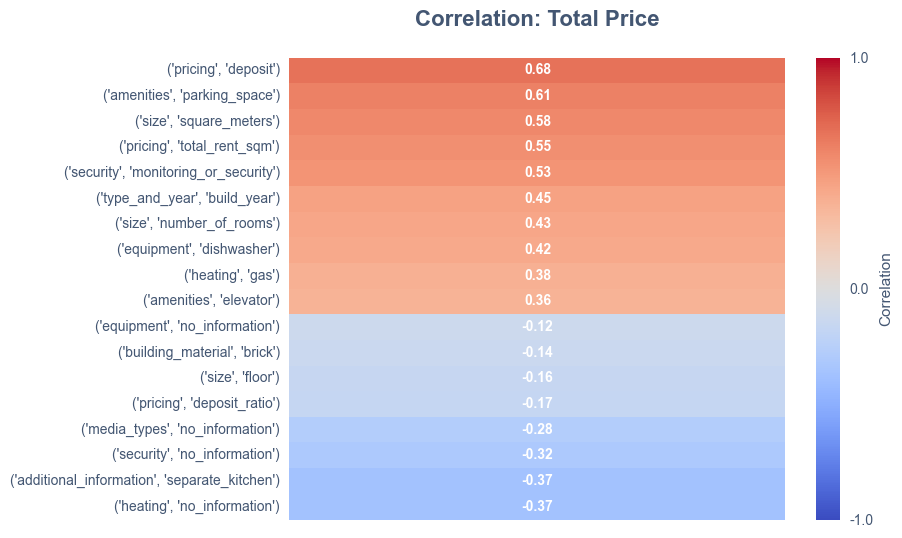

In [24]:
show_extreme_correlations(offers_5km_df, ('pricing', 'total_rent'), num_results = 10, title="Total Price")

**Insights Total Price Correlations:**

1. **Parking Space**:<br>
 The availability of a parking space has a strong positive `(0.68)` correlation with the total price,<br>
 indicating that properties with parking facilities tend to be higher priced.

1. **Size Matters**:<br>
The apartment size, measured in square meters, has a significant positive correlation `(0.58)` with the total price,<br>
meaning larger apartments tend to be more expensive.<br>
The number of rooms also shows a positive correlation `(0.43)` with price, though it's not as strong as the size in square meters,<br>indicating that the overall size may be more influential on price than the mere number of rooms.

1. **Security**:<br>
The presence of monitoring or security services shows a moderate positive correlation `(0.53)`

1. **Age of the building**:<br>
The age matters moderately `(0.45)`

Other correlations:

In [25]:
print_correlations(offers_5km_df)


Strong Correlations:
('building_material', 'aerated_concrete') - ('additional_information', 'air_conditioning'): 1.0
('pricing', 'price') - ('pricing', 'total_rent'): 0.89
('type_and_year', 'build_year') - ('security', 'monitoring_or_security'): 0.88
('equipment', 'stove') - ('equipment', 'fridge'): 0.87
('equipment', 'furniture') - ('equipment', 'washing_machine'): 0.82
('media_types', 'internet') - ('media_types', 'cable_TV'): 0.81
('amenities', 'elevator') - ('building_material', 'hollow_brick'): 0.8
('equipment', 'stove') - ('equipment', 'furniture'): 0.8
('equipment', 'fridge') - ('equipment', 'furniture'): 0.8
('equipment', 'stove') - ('equipment', 'oven'): 0.78
('equipment', 'stove') - ('equipment', 'washing_machine'): 0.75
('equipment', 'fridge') - ('equipment', 'washing_machine'): 0.75
('amenities', 'elevator') - ('security', 'monitoring_or_security'): 0.75
('pricing', 'rent') - ('type_and_year', 'build_year'): 0.73
('pricing', 'total_rent_sqm') - ('type_and_year', 'build_yea

**Insights Other Correlations:**

1. **Highly Correlated Equipment**:<br>
There's a strong positive correlation between pairs of equipment, such as `stoves` and `fridges` (`0.87`), and between `furniture` and `washing machines` (`0.82`). This indicates that these amenities often come together in listings, suggesting a trend in rental properties being equipped with a full set of essential household appliances.

1. **Impact of Building Material and Amenities on Rent**:<br>
`Aerated concrete` as a `building material` and the presence of `air conditioning` are perfectly correlated (`1.0`), which may imply that newer or recently renovated buildings with this material are more likely to have modern amenities like air conditioning. Additionally, the strong correlation between `build year` and `security features` (`0.88`) suggests that newer buildings are more likely to have advanced security systems.

1. **Building Year and Heating Types**:<br>
There are negative correlations between the building year and various heating types, such as district heating (`-0.32`) and electric heating (`-0.68`). This might indicate that newer buildings are less likely to use these forms of heating, possibly due to advancements in building technology and preferences for more modern heating systems.



### 2.4 Attributes and equipment

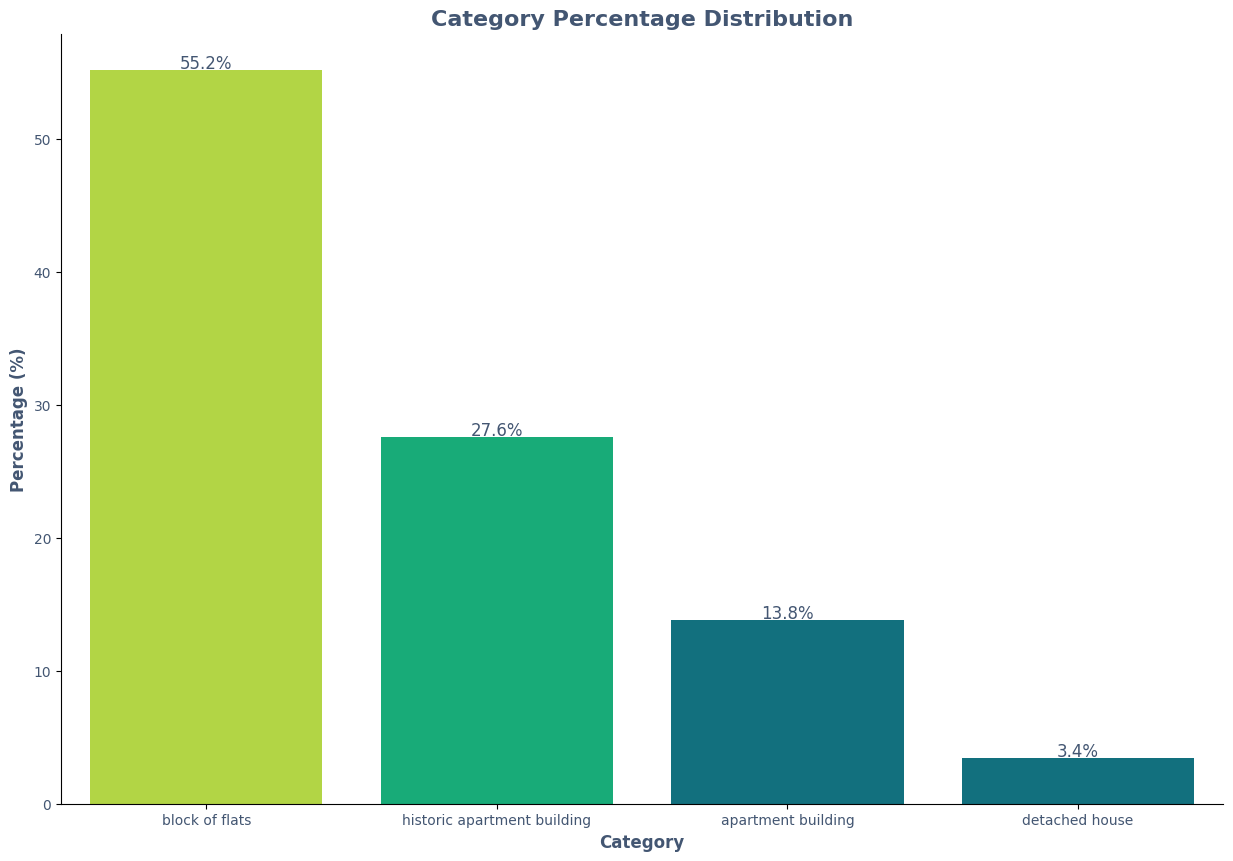

In [29]:
def display_category_proportions(data: pd.Series, title: str):
    # Check if data is a Series and of string type
    if not isinstance(data, pd.Series) or data.dtype != 'string[python]':
        raise TypeError("Data must be a pandas Series with string type.")

    # Calculate the percentage of each category
    category_percentage = data.value_counts(normalize=True) * 100

    # Create a bar plot
    fig, ax = plt.subplots(figsize=aesthetics_plots["figsize"]["multiplot"])
    my_palette = ['#bfed2d'] + ['#00c37f'] + ["#007e90"] + ['#51006f']*2

    unique_categories = data.unique()
    length = len(unique_categories)
    if (length - 5) <= 0:
        adjusted_length = 1
    else:
        adjusted_length = length - 5
    my_palette = ['#bfed2d'] + ['#00c37f'] + ["#007e90"]*2 + ['#51006f']*adjusted_length

    # Make the index more readable
    more_readable_index = []
    for _index in category_percentage.index:
        more_readable_index.append(_index.replace('_', ' '))
    category_percentage.index = more_readable_index

    sns.barplot(x=category_percentage.index, y=category_percentage.values, ax=ax, palette=my_palette)
    
    # Add labels to the plot
    plt.title(title, color=aesthetics_plots['label_color'], fontsize=aesthetics_plots['title_size'], weight=aesthetics_plots['fontweight'])
    plt.xlabel('Category', color=aesthetics_plots['label_color'], fontsize=aesthetics_plots['y_and_x_label_size'], weight=aesthetics_plots['fontweight'])
    plt.ylabel('Percentage (%)', color=aesthetics_plots['label_color'], fontsize=aesthetics_plots['y_and_x_label_size'], weight=aesthetics_plots['fontweight'])

    plt.xticks(color=aesthetics_plots['label_color'])
    plt.yticks(color=aesthetics_plots['label_color'])
    
    sns.despine(right=True, top=True)


    # Add percentage labels on the bars
    for p in ax.patches:
        ax.annotate(f"{p.get_height():.1f}%", (p.get_x() + p.get_width() / 2., p.get_height()),
                    ha='center', va='center', fontsize=12, color=aesthetics_plots['label_color'], xytext=(0, 5),
                    textcoords='offset points')

    # Display the plot
    plt.show()


display_category_proportions(offers_5km_df[('type_and_year', 'building_type')], "Category Percentage Distribution")

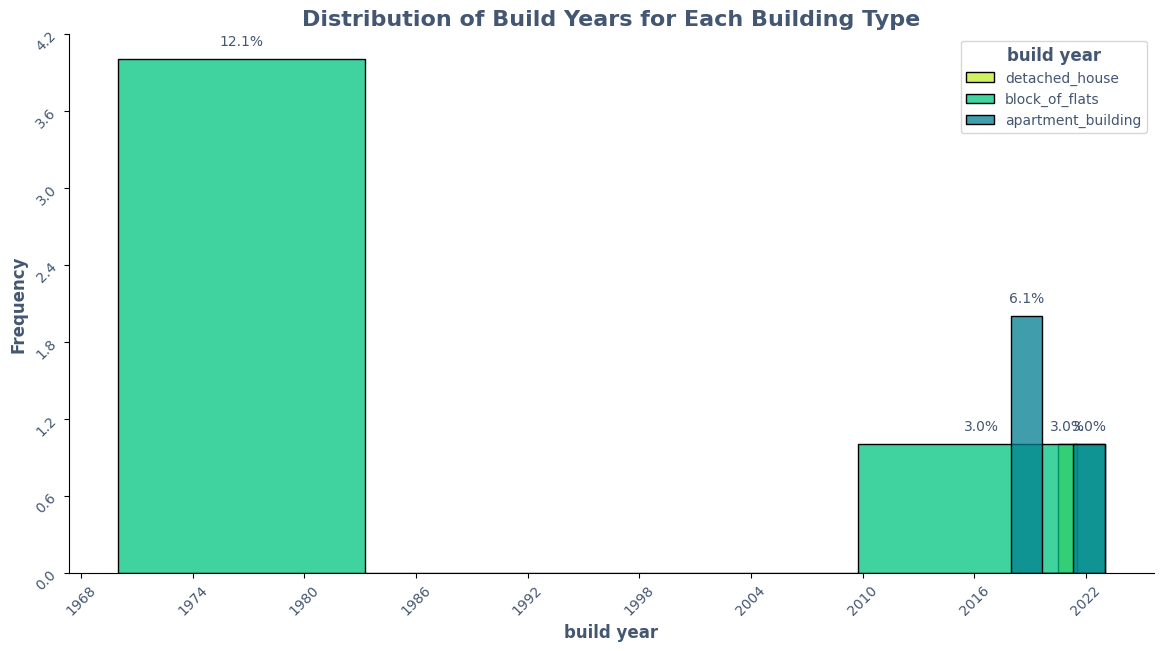

In [30]:
show_categorical_data_percentage_distribution(
    offers_5km_df,  
    ('type_and_year', 'building_type'),
    ('type_and_year', 'build_year'),
    'Distribution of Build Years for Each Building Type'
    )

In [52]:
show_distribution_details([('type_and_year', 'building_type'), ('type_and_year', 'build_year')])

,"(type_and_year, building_type)","(type_and_year, build_year)",count
1,apartment_building,2018.0,1
2,apartment_building,2019.0,1
3,apartment_building,2023.0,1
0,block_of_flats,1970.0,2
4,block_of_flats,1980.0,1
5,block_of_flats,1983.0,1
6,block_of_flats,2023.0,1
7,detached_house,2021.0,1


**Insights Building Type and Build Year**:
1. **Block of Flats Era**:<br>
There's a noticeable cluster of block of flats built around `1970`, and in `80's`. Recent activity is minimal with a lone entry in `2023`.
1. **Modern Apartment Trend**:<br>
Apartment buildings in the dataset are all from `2018` onwards, suggesting a trend towards newer apartment constructions.

In [31]:
def move_index_to_last(series, index_to_move):
    """
    Moves a specified index to the last position in a pandas Series.

    Args:
    series (pd.Series): The original series.
    index_to_move (str): The index to be moved to the last position.

    Returns:
    pd.Series: A new series with the specified index moved to the last position.
    """
    if index_to_move not in series.index:
        raise ValueError(f"Index '{index_to_move}' not found in the Series.")

    # Extracting the indices
    idx_list = series.index.tolist()

    # Remove the index to move and then append it at the end
    idx_list.remove(index_to_move)
    idx_list.append(index_to_move)

    # Reindexing the series
    return series.reindex(idx_list)

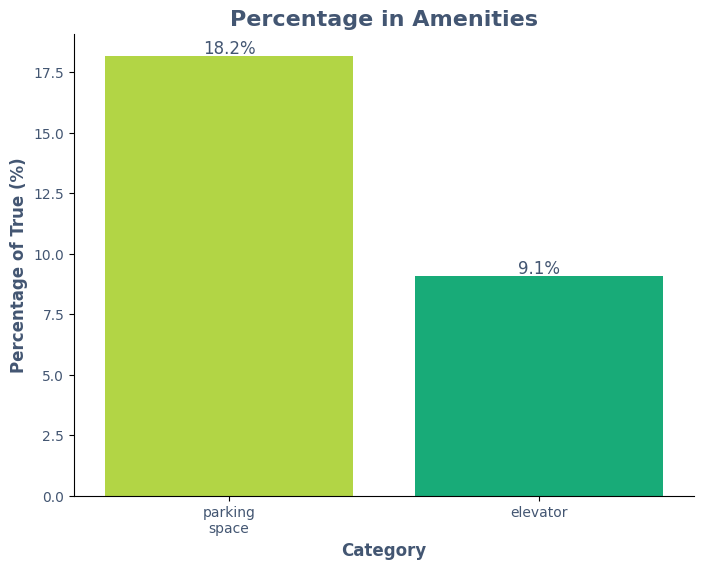

In [32]:
def visualize_true_percentage_by_category(df: pd.DataFrame, main_category: str):
    # Check if the DataFrame contains the main category
    if main_category not in df.columns.get_level_values(0):
        raise KeyError(f"Main category '{main_category}' not found in DataFrame.")

    # Extract subcategories for the given main category
    subcategories = [col for col in df.columns if col[0] == main_category]

    # Calculate percentage of True values for each subcategory
    percentages = {}
    for subcat in subcategories:
        percentages[subcat[1]] = (df[subcat].sum() / len(df)) * 100

    # Convert to Series for plotting
    category_percentage = pd.Series(percentages)

    # Sort by percentage, 'no_information' should be last
    category_percentage = category_percentage.sort_values(ascending=False)
    if 'no_information' in category_percentage.index:
        category_percentage = move_index_to_last(category_percentage, 'no_information')

    # Create a bar plot
    if category_percentage.index.__len__() >= 5:
        plot_size = aesthetics_plots["figsize"]["multiplot"]
    else:
        plot_size = aesthetics_plots["figsize"]["singleplot"]

    fig, ax = plt.subplots(figsize=plot_size)

    # Set the palette
    length = len(category_percentage.index)
    if (length - 5) <= 0:
        adjusted_length = 1
    else:
        adjusted_length = length - 5
    my_palette = ['#bfed2d'] + ['#00c37f'] + ["#007e90"]*2 + ['#51006f']*adjusted_length

    if 'no_information' in category_percentage.index:
        my_palette = my_palette[:max(1, length - 1)] + ['#b3b3b3']

    more_readable_index = []
    for _index in category_percentage.index:
        more_readable_index.append(_index.replace('_', '\n'))

    category_percentage.index = more_readable_index

    sns.barplot(x=category_percentage.index, y=category_percentage.values, ax=ax, palette=my_palette)
    
    # Add labels to the plot
    title = "Percentage in " + main_category.replace('_', ' ').title()
    plt.title(title, color=aesthetics_plots['label_color'], fontsize=aesthetics_plots['title_size'], weight=aesthetics_plots['fontweight'])
    plt.xlabel('Category', color=aesthetics_plots['label_color'], fontsize=aesthetics_plots['y_and_x_label_size'], weight=aesthetics_plots['fontweight'])
    plt.ylabel('Percentage of True (%)', color=aesthetics_plots['label_color'], fontsize=aesthetics_plots['y_and_x_label_size'], weight=aesthetics_plots['fontweight'])

    plt.xticks(color=aesthetics_plots['label_color'])
    plt.yticks(color=aesthetics_plots['label_color'])
    
    sns.despine(right=True, top=True)

    # Add percentage labels on the bars
    for p in ax.patches:
        ax.annotate(f"{p.get_height():.1f}%", (p.get_x() + p.get_width() / 2., p.get_height()),
                    ha='center', va='center', fontsize=12, color=aesthetics_plots['label_color'], xytext=(0, 5),
                    textcoords='offset points')

    # Display the plot
    plt.show()

visualize_true_percentage_by_category(offers_5km_df, 'amenities')

**Insights Amenities**:
1. **Parking Space**:<br>
are included in `18.2%` of the apartment offers.
1. **Elevator**<br>
are available in `9.1%` of the listings.

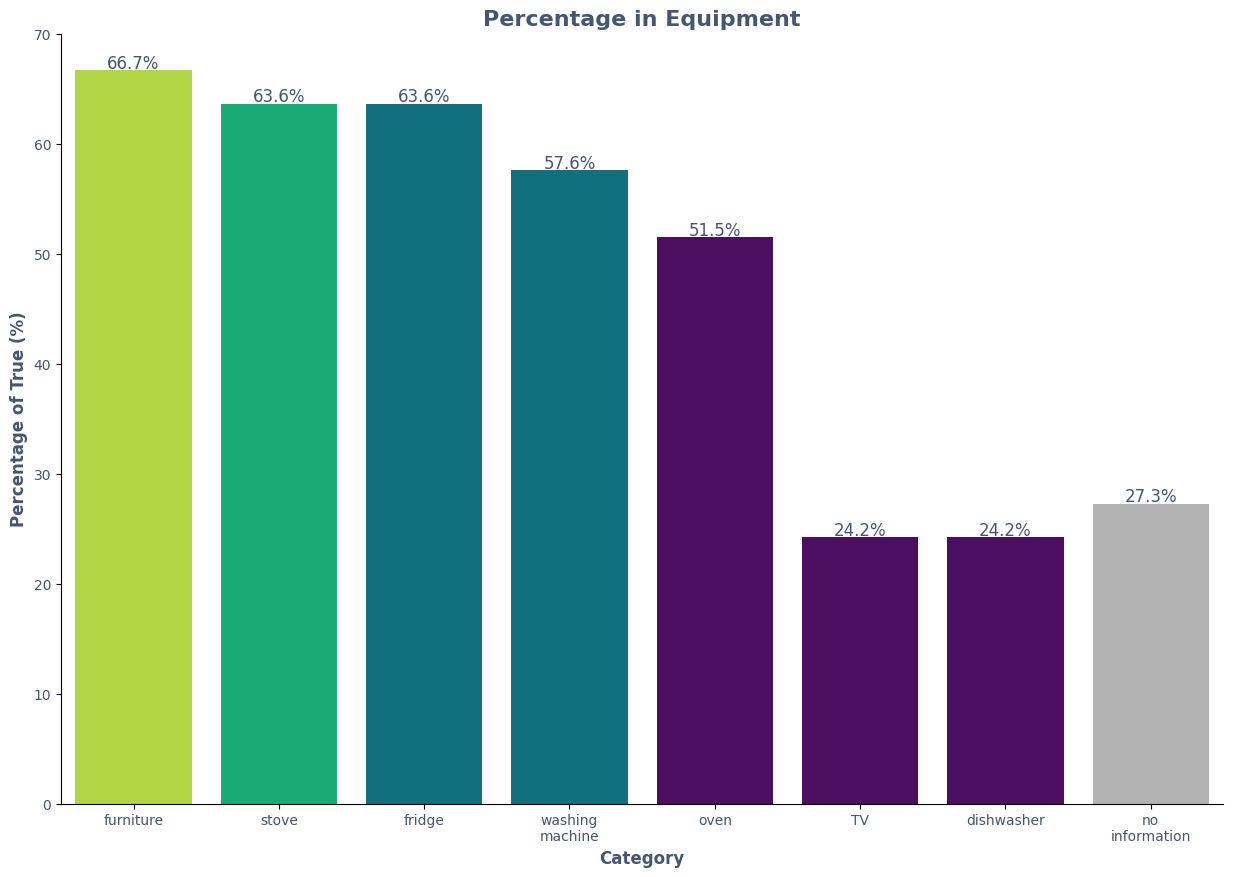

In [33]:
visualize_true_percentage_by_category(offers_5km_df, 'equipment')

**Insights Equipment**:

1. **Trends in home furnishings**:<br>
A significant majority of listings include `furniture`, `stove`, and `fridge`, each present in over `60%` of properties, making them standard offerings.
The `washing machine` and the oven are over the `50%`.
1. **Rarer amenities**:<br>
`TVs` and `dishwashers` are less common, featured in about a quarter of the listings, indicating they are considered luxury items or optional.

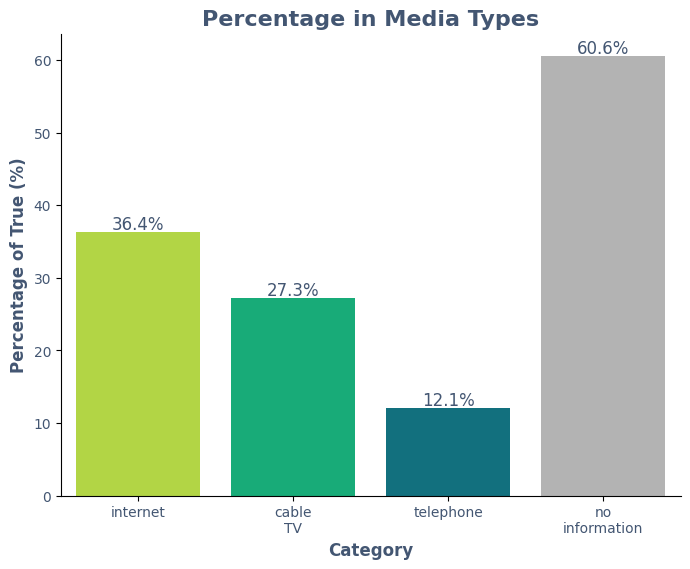

In [34]:
visualize_true_percentage_by_category(offers_5km_df, 'media_types')

**Insights Media Types**:
1. **Universality**:<br>
`Internet access` is mentioned in `36.4%` of the listings and, `27.3%` for the `cable tv`.
`telephone` is the only `12.1%` listings.
1. **No information**:<br>
about media types are reported in `60.6%` of the offers, showing that for most it's irrelevant information.

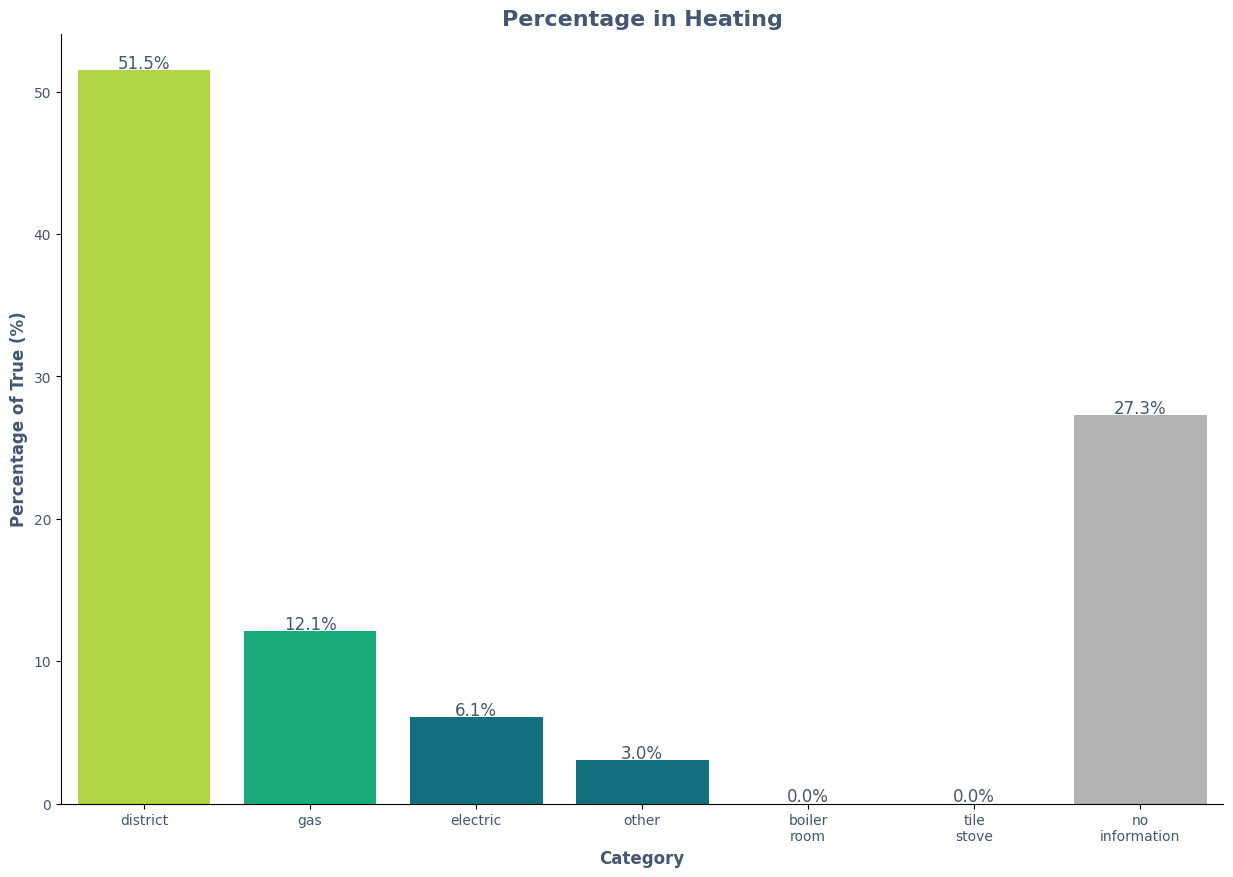

In [35]:
visualize_true_percentage_by_category(offers_5km_df, 'heating')

**Insights Heating**:

1. **District heating**:<br>
is the most reported type at `51.5%`, reflecting its widespread use in urban settings or apartment complexes.
1. **Othe heating**:<br>
The `gas` `12.1%` and especially `electric` `6.1%` heating is low due to high costs.

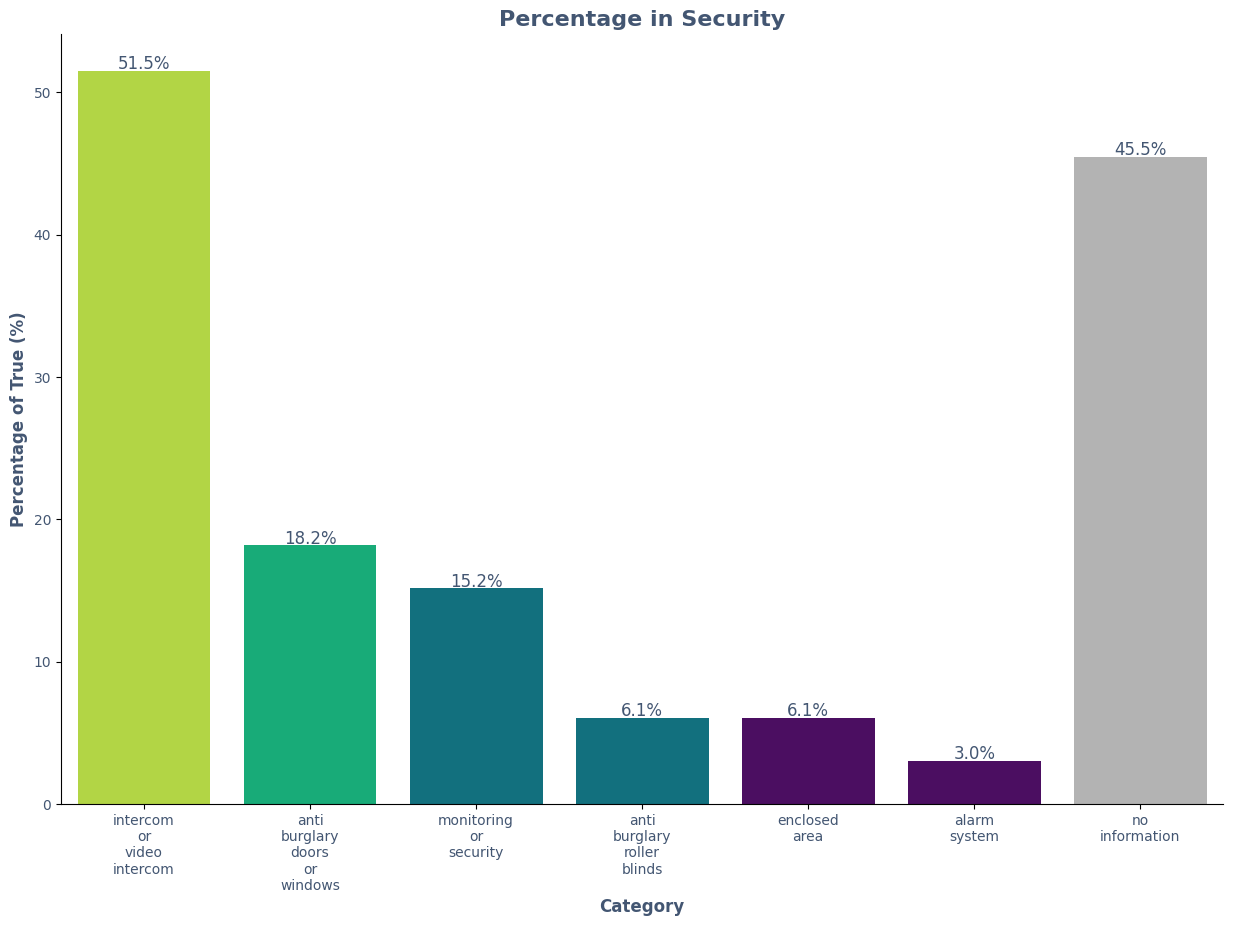

In [36]:
visualize_true_percentage_by_category(offers_5km_df, 'security')

**Insights Security**:

1. **Intercom Systems**:<br>
`Intercom` or `video intercom` systems are noted in `51.5%` of the offers, quite common feature.
1. **More advanced security features**:<br>
like `anti-burglary roller blinds` and `enclosed area` are mentioned in only `6.1%` of the listings, and `alarm systems` in `3.0%`, suggesting that these may be less common or highlighted only in premium offerings.

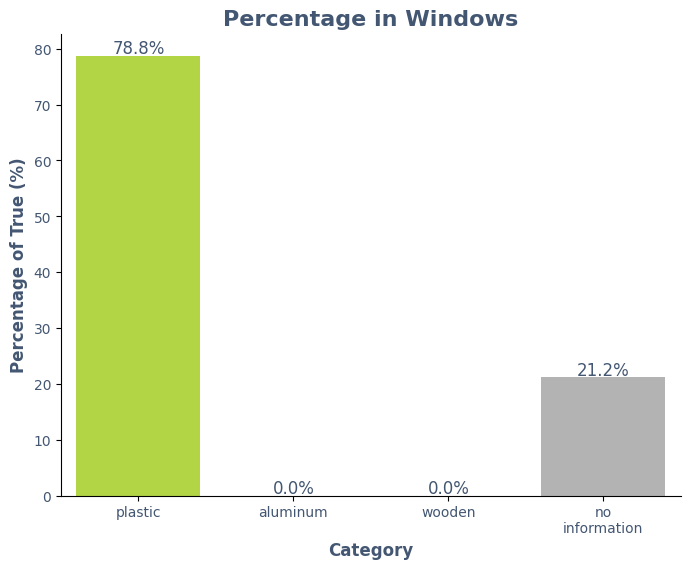

In [37]:
visualize_true_percentage_by_category(offers_5km_df, 'windows')

**Insights Windows**:

1. **Plastic**:<br>
windows dominate the features at `78.8%`.

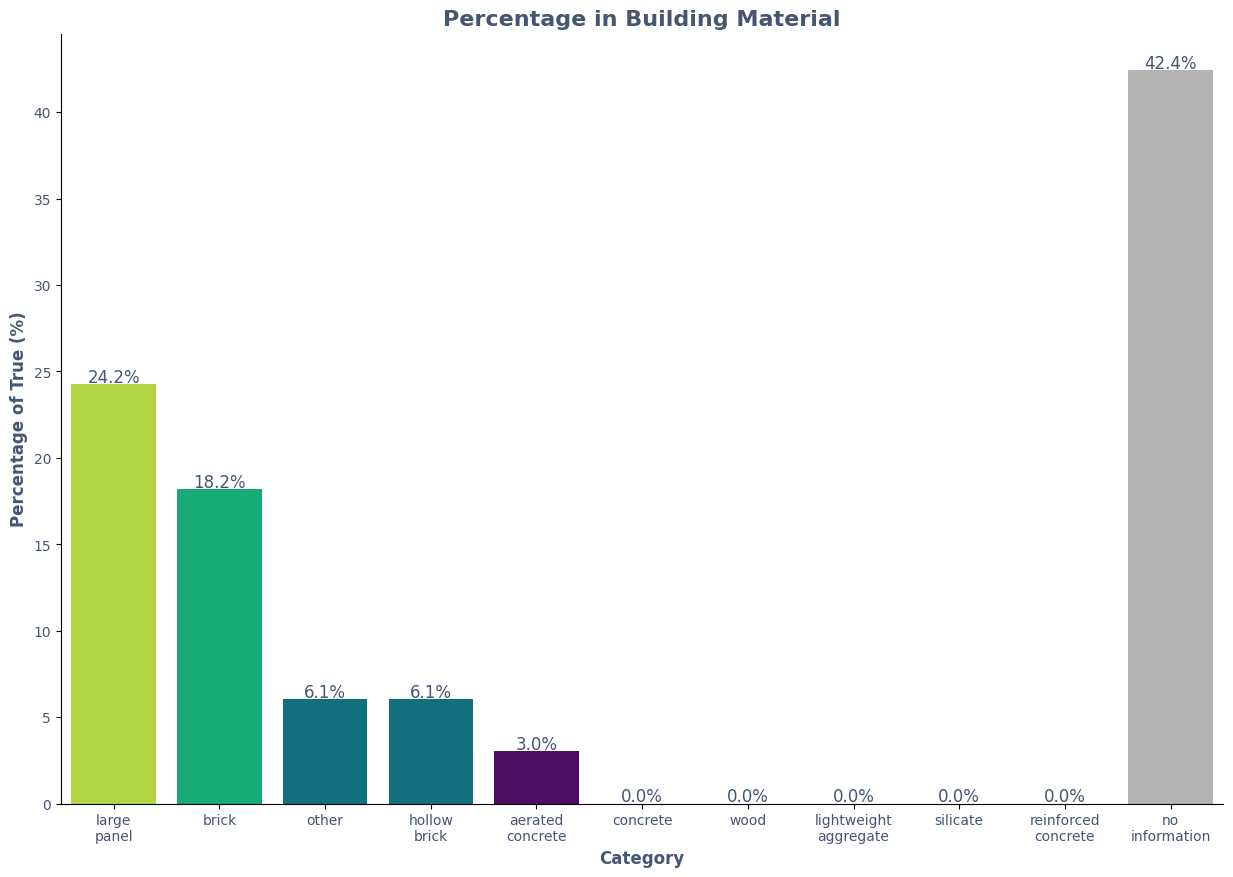

In [38]:
visualize_true_percentage_by_category(offers_5km_df, 'building_material')

**Insights Building Material**:

1. **Large panel**:<br>
is mentioned in `24.2%`, but the result could be undermined by not mentioning it due to unpopularity among prospective tenants.
1. **Brick**:<br>
is specified in `18.2%` of the properties, possibly due to its desirable qualities such as durability and insulation.
1. **No information**:<br>
Almost half of the listings, at `42.4%`, do `not disclose` building material.

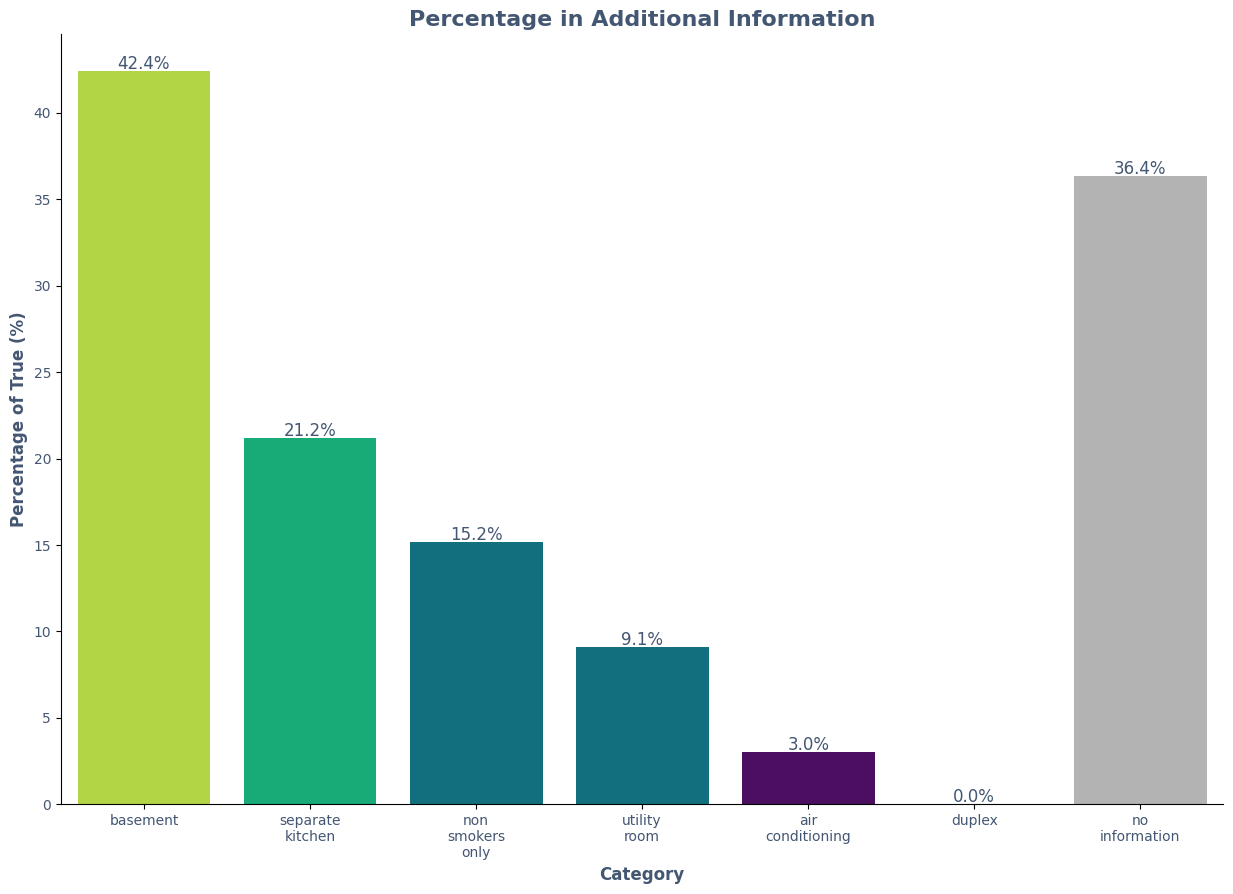

In [39]:
visualize_true_percentage_by_category(offers_5km_df, 'additional_information')

**Additional Information Plot Insights**:
1. **Basements are prevalent:**<br>
`Basements` are the most common feature listed, found in over `40%` of the properties, suggesting they are a popular and expected property feature.

1. **Separate Kitchens and Non-Smokers:**<br>
`Separate kitchens` are also a notable feature, present in about `21%` of listings, indicating a preference or demand for this layout. Additionally, properties specifying `'non-smokers only'` make up over `15%`

1. **Air Conditioning is Rare:**<br>
`Air conditioning` is quite rare, appearing in only `3%` of listings.<br>
Conversely, there is a significant portion (`36.4%`) of listings without additional information provided.